In [1]:
import os
from collections import OrderedDict
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import glob
import seaborn as sns

from scipy.stats import ttest_ind as tt
from scipy.stats import wilcoxon, spearmanr, permutation_test
import scanpy as sc
import anndata as ad

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(5,5), frameon=False)

In [2]:
run_name = "Graph-Perciever_September-17"
fold_idx = 2
features_path = os.path.join("/SeaExp/Rushin/TNTA/logs/", run_name+"_fold_{}".format(fold_idx))
lusc_metadata_path = os.path.join("/SeaExp/Rushin/datasets/", "CPTAC", "LSCC_meta.csv")
luad_metadata_path = os.path.join("/SeaExp/Rushin/datasets/", "CPTAC", "LUAD_meta.csv")
luad_metadata2_path = os.path.join("/SeaExp/Rushin/datasets/", "CPTAC", "LUAD_meta2.csv")

In [3]:
all_adata = sc.read_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))
cptac_adata = all_adata.copy()
cptac_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'

In [4]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score
# subset cptac with cohort_names == "CPTAC"
q = cptac_adata[cptac_adata.obs['cohort_names'] == "CPTAC"]

ami_score = adjusted_mutual_info_score(q.obs['labels'], q.obs['model_predictions'])
ar_score = adjusted_rand_score(q.obs['labels'], q.obs['model_predictions'])
# q.obs['labels'].value_counts()
print(ami_score, ar_score)

0.642436752734755 0.6923707731183271


In [5]:
pca = cptac_adata.obsm['X_pca']
cptac_pca_adata = ad.AnnData(pca, obs=cptac_adata.obs, 
                             uns={'neighbors': cptac_adata.uns['neighbors'], 'pca': cptac_adata.uns['pca'], 'tsne': cptac_adata.uns['tsne'], 'umap': cptac_adata.uns['umap']},
                             obsm={'X_pca': cptac_adata.obsm['X_pca'], 'X_tsne': cptac_adata.obsm['X_tsne'], 'X_umap': cptac_adata.obsm['X_umap']}, 
                             obsp={'connectivities': cptac_adata.obsp['connectivities'], 'distances': cptac_adata.obsp['distances']})

cptac_pca_adata.var_names = ['PC_{}'.format(i) for i in cptac_pca_adata.var_names]
cptac_pca_adata = cptac_pca_adata[cptac_pca_adata.obs.cohort_names == 'CPTAC']
cptac_pca_adata

View of AnnData object with n_obs × n_vars = 2071 × 50
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [6]:
lusc_metadata = pd.read_csv(lusc_metadata_path, header = 0)
luad_metadata = pd.read_csv(luad_metadata2_path, header=0)

lusc_metadata = lusc_metadata[['Slide_ID', 'Tumor', 'Specimen_Type', 'Tumor_Histological_Type']]
luad_metadata = luad_metadata[['Slide_ID', 'Tumor', 'Specimen_Type', 'Tumor_Histological_Type']]

cptac_metadata = pd.concat([lusc_metadata, luad_metadata])
cptac_metadata.index = cptac_metadata['Slide_ID']
del cptac_metadata['Slide_ID']

In [7]:
cptac_metadata

,Tumor,Specimen_Type,Tumor_Histological_Type
Slide_ID,,,
C3L-05417-25,LSCC,tumor_tissue,Keratinizing squamous cell carcinoma
C3L-04391-22,LSCC,tumor_tissue,Squamous cell carcinoma
C3L-05427-24,LSCC,tumor_tissue,Keratinizing squamous cell carcinoma
C3L-03987-23,LSCC,tumor_tissue,Squamous cell carcinoma
C3L-03987-24,LSCC,tumor_tissue,Squamous cell carcinoma
...,...,...,...
C3N-00203-21,LUAD,tumor_tissue,Adenosquamous
C3N-01030-23,LUAD,tumor_tissue,Adenosquamous
C3N-01030-24,LUAD,tumor_tissue,Adenosquamous


In [8]:
cptac_sample_names = cptac_pca_adata.obs_names
for col in cptac_metadata.columns:
    cptac_adata.obs[col] = cptac_metadata.loc[cptac_sample_names, col]
    cptac_pca_adata.obs[col] = cptac_metadata.loc[cptac_sample_names, col]

cptac_adata.obs['pc1'] = cptac_adata.obsm['X_pca'][:, 0]
cptac_adata.obs['pc2'] = cptac_adata.obsm['X_pca'][:, 1]

cptac_pca_adata.obs['pc1'] = cptac_pca_adata.obsm['X_pca'][:, 0]
cptac_pca_adata.obs['pc2'] = cptac_pca_adata.obsm['X_pca'][:, 1]


cptac_pca_adata

AnnData object with n_obs × n_vars = 2071 × 50
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'Tumor', 'Specimen_Type', 'Tumor_Histological_Type'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

### Categorical Heatmaps [PC1 - PC2]

In [9]:
cptac_pca_adata.obs['normal_adjacent_to'] = cptac_pca_adata.obs.loc[cptac_pca_adata.obs.labels=='normal', 'Tumor'] 
cptac_pca_adata.obs['keratinization_status'] = cptac_pca_adata.obs.loc[cptac_pca_adata.obs.Tumor_Histological_Type.isin(['Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma']), 'Tumor_Histological_Type']
cptac_pca_adata.obs['luad_subtypes'] = cptac_pca_adata.obs.loc[cptac_pca_adata.obs.Tumor_Histological_Type.isin(['Micropapillary/Solid', 'Acinar/Papillary/Lepidic']), 'Tumor_Histological_Type']
plotting_obs_keys = ['Specimen_Type', 'labels', 'Tumor']
cptac_pca_adata

AnnData object with n_obs × n_vars = 2071 × 50
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'Tumor', 'Specimen_Type', 'Tumor_Histological_Type', 'normal_adjacent_to', 'keratinization_status', 'luad_subtypes'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

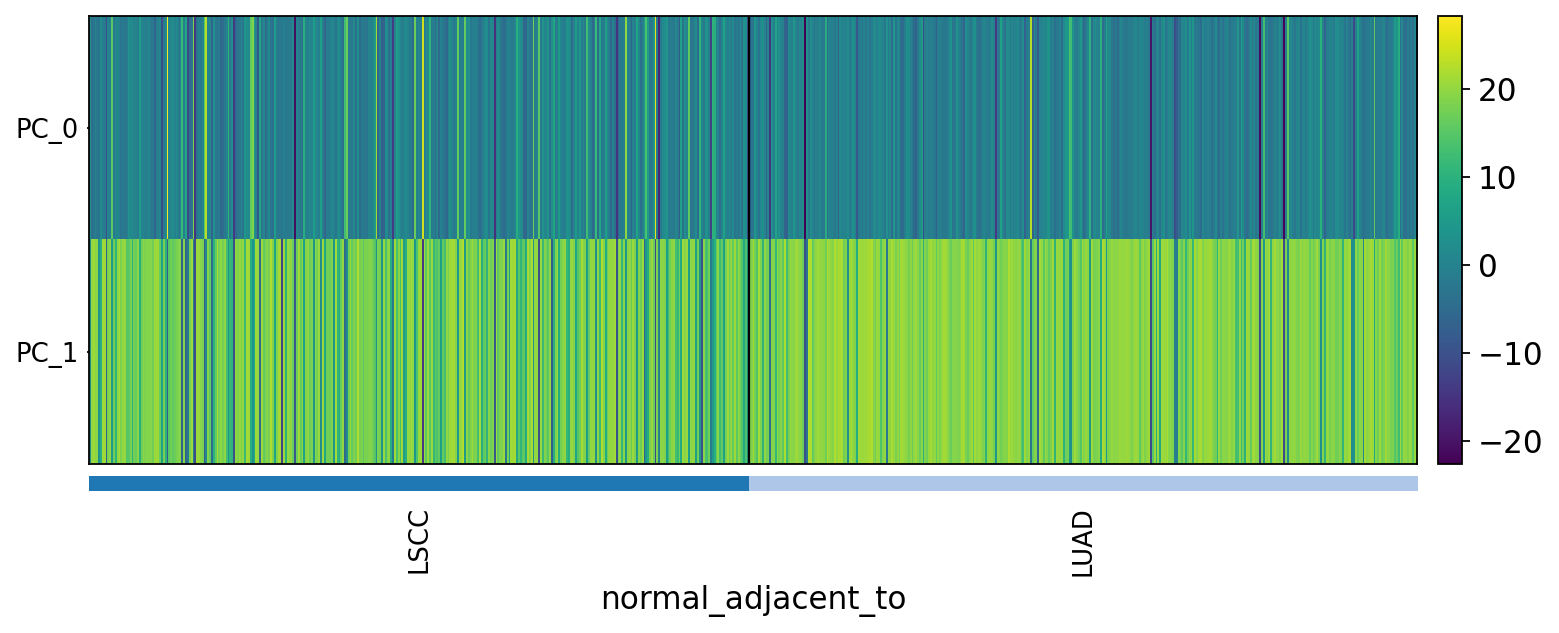

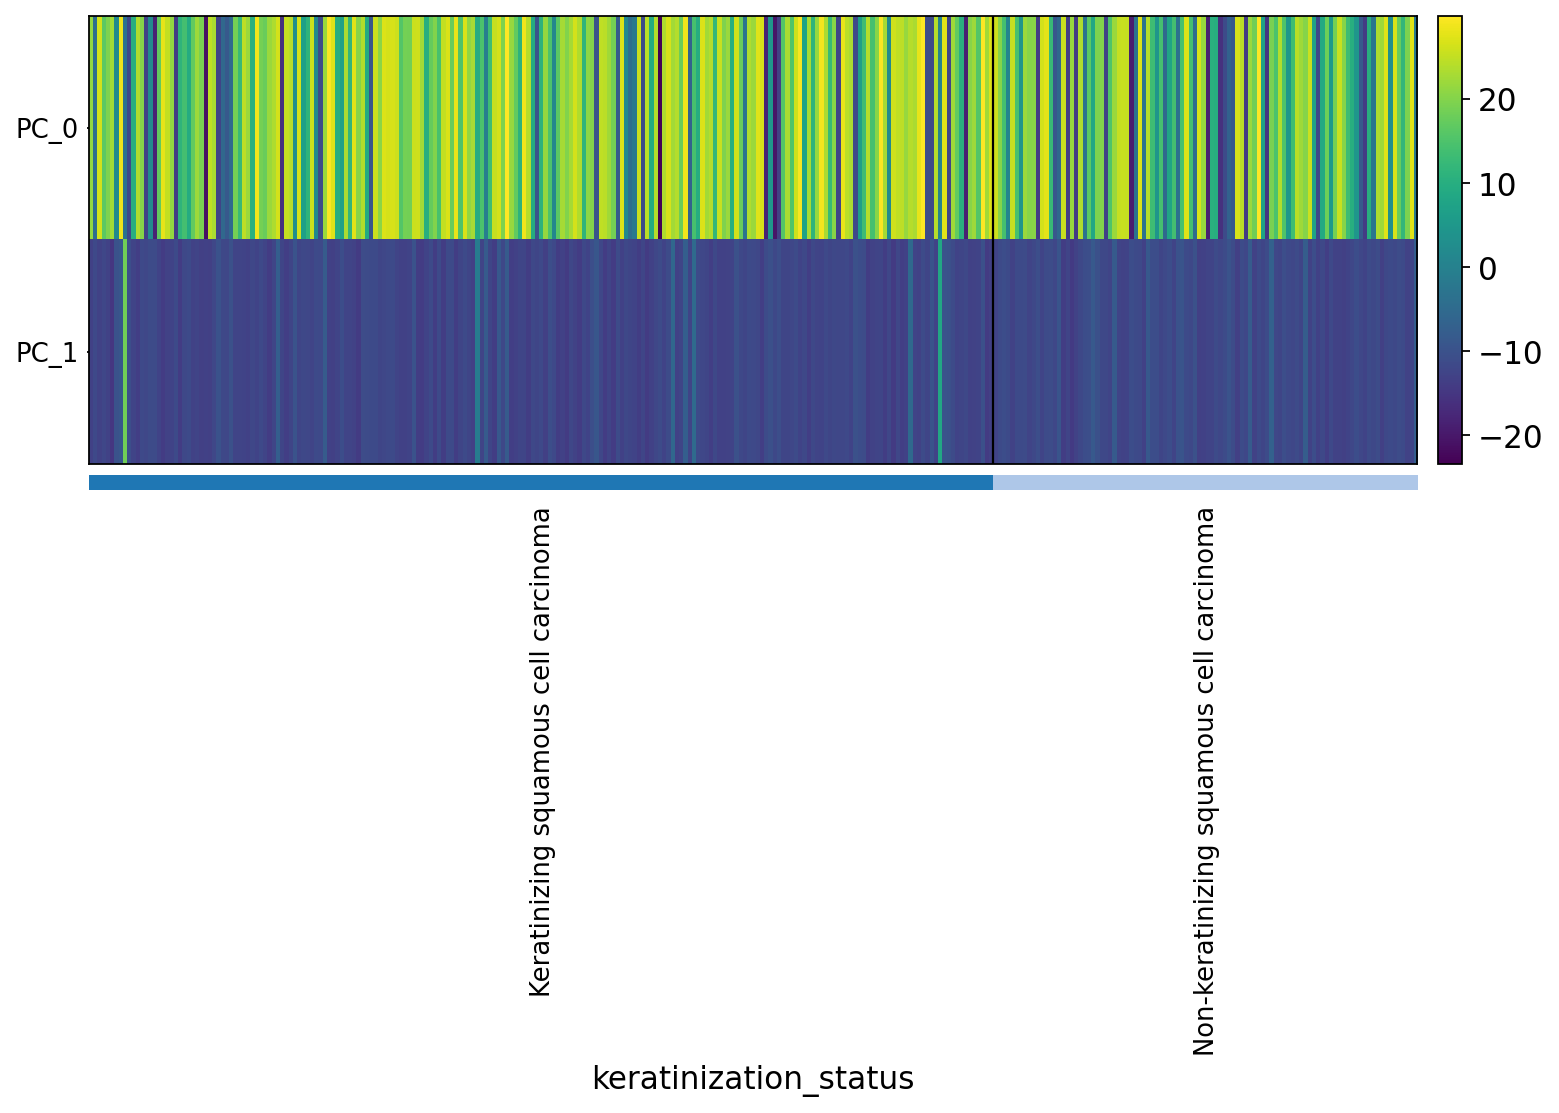

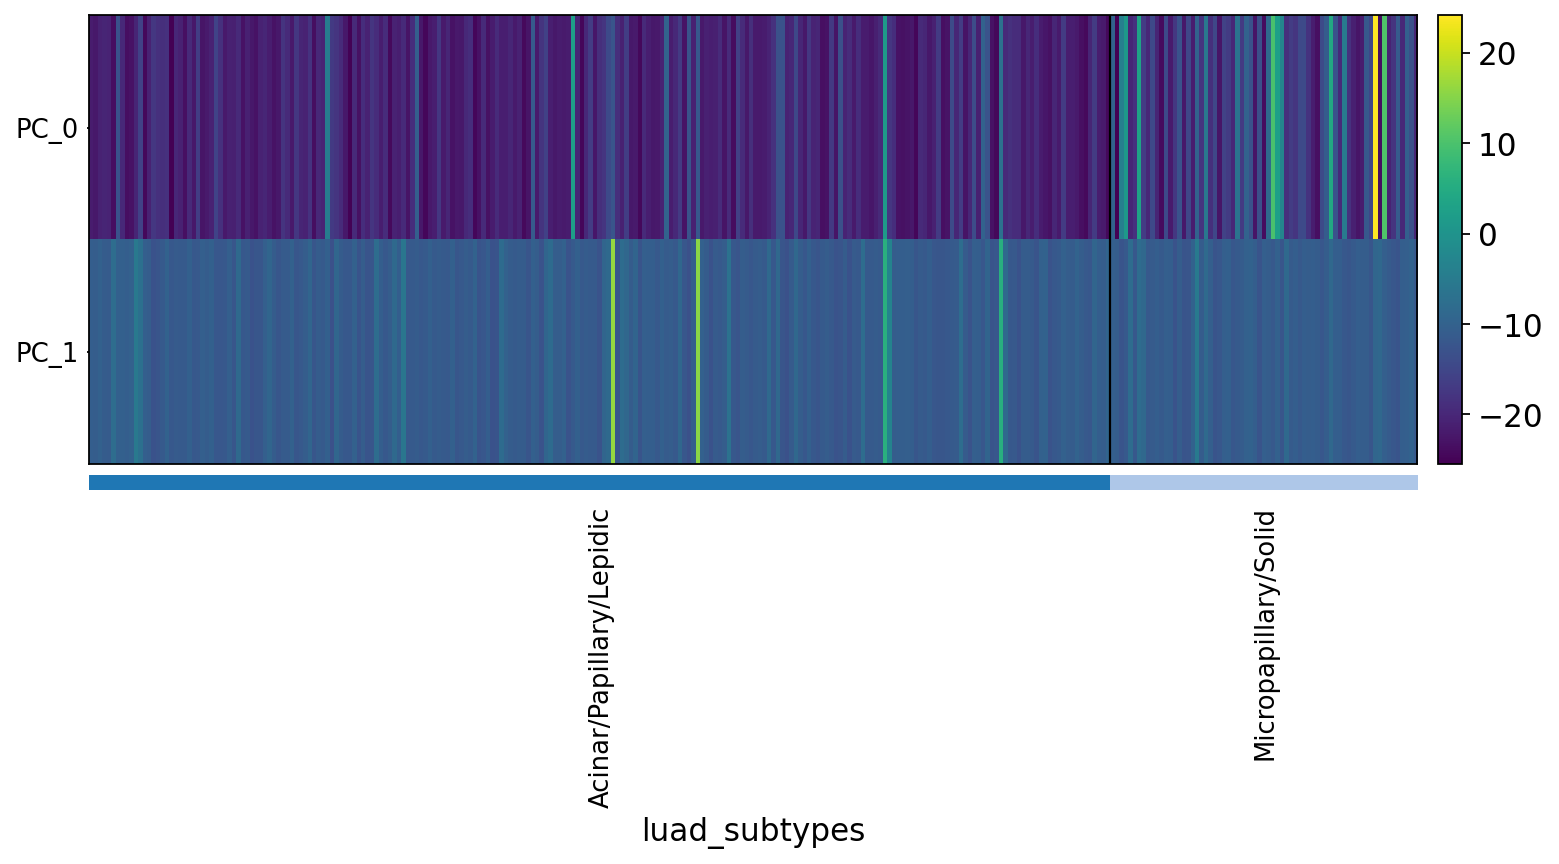

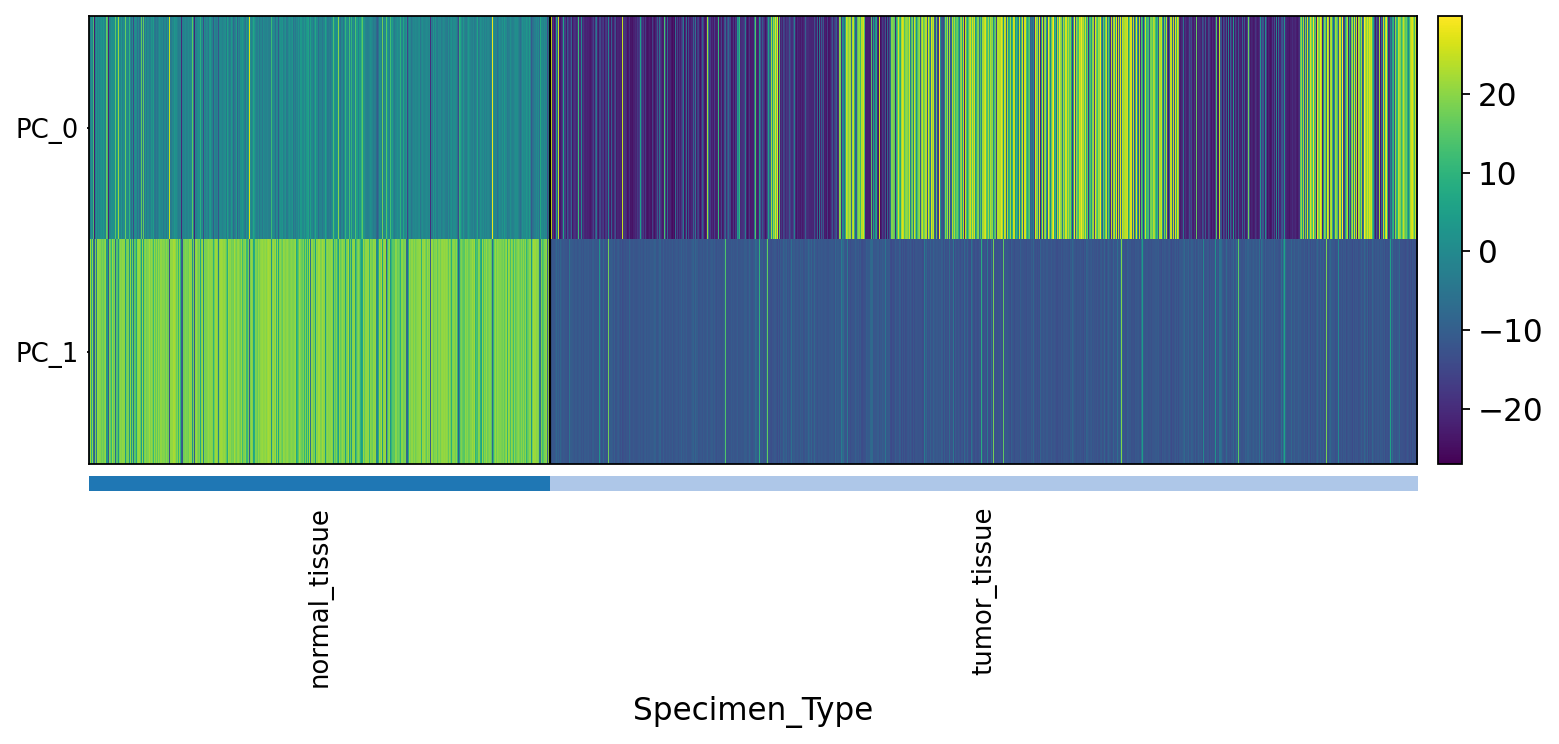

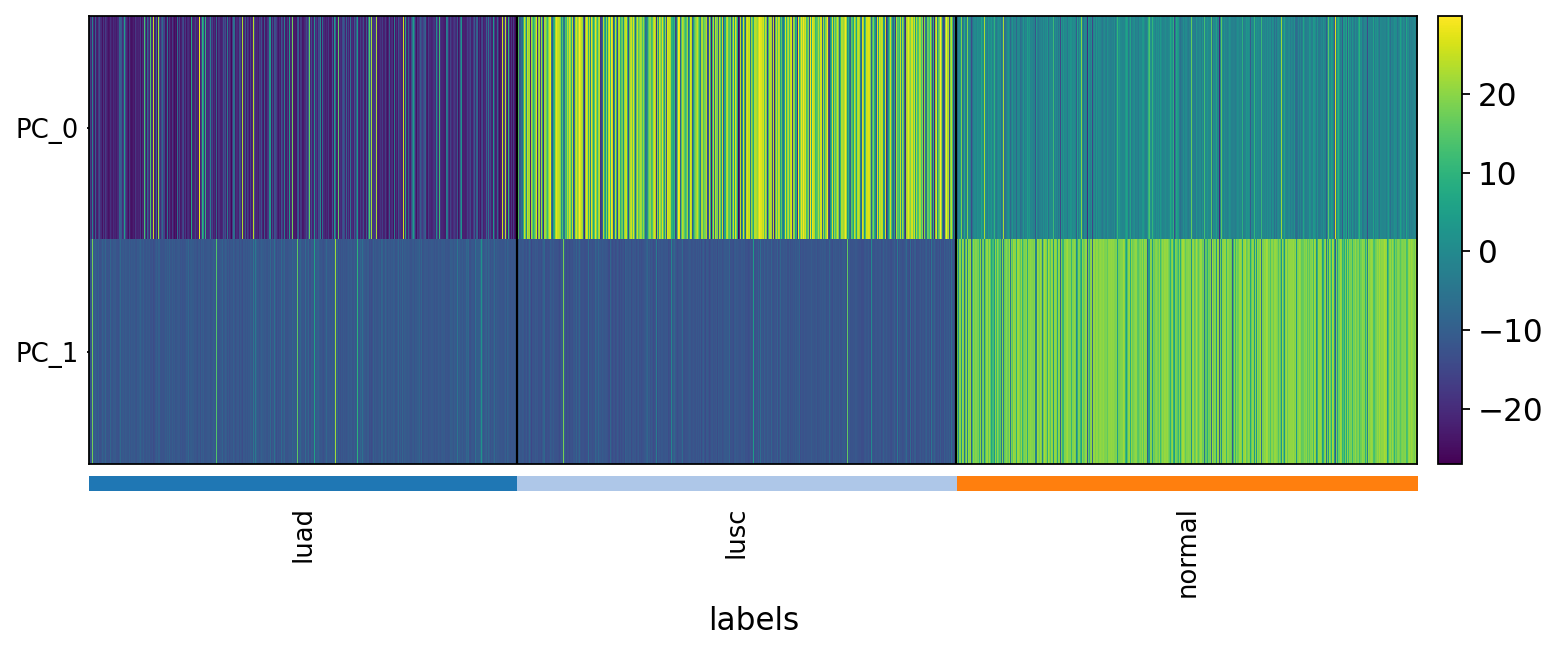

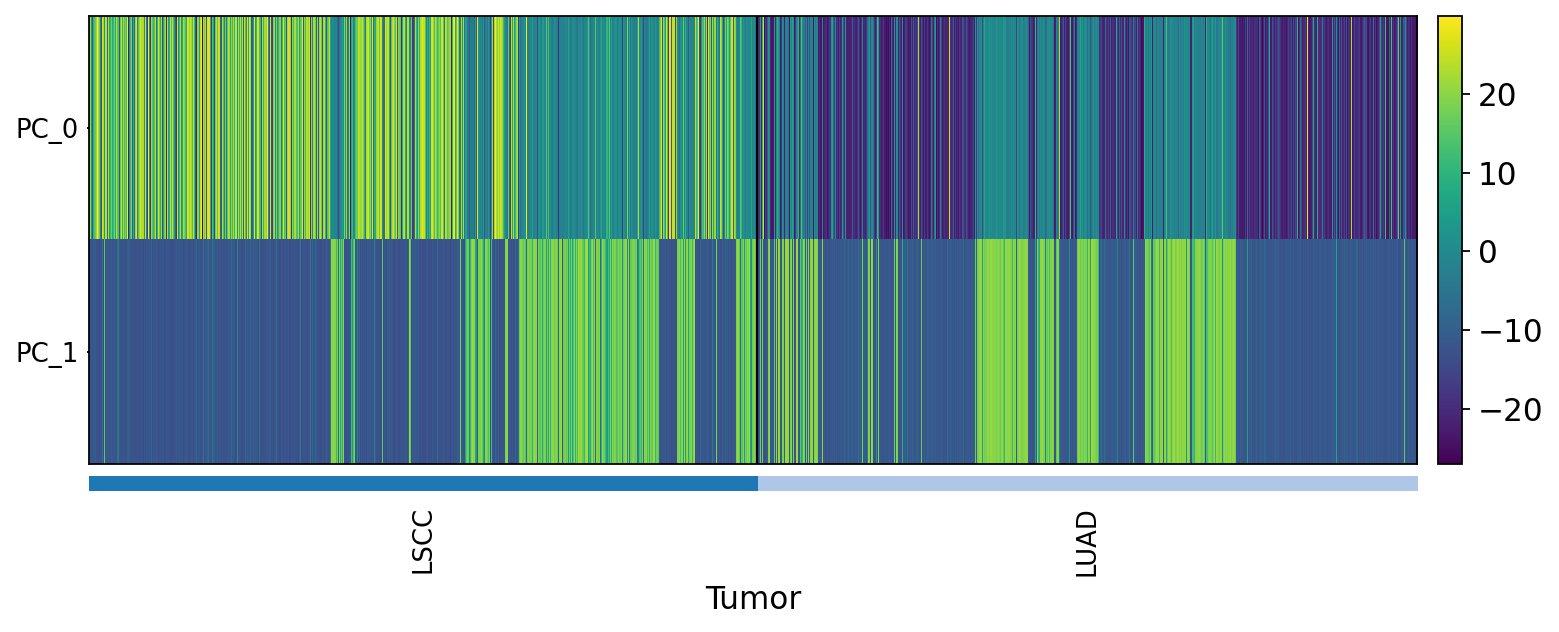

In [10]:
# plotting heatmap for PC 1 - 2 Variables and all categories in obs (groupby)
sc.pl.heatmap(cptac_pca_adata[~cptac_pca_adata.obs['normal_adjacent_to'].isnull()], var_names=cptac_pca_adata.var_names[0:2], groupby=['normal_adjacent_to'], swap_axes=True, figsize=(11,4))
sc.pl.heatmap(cptac_pca_adata[~cptac_pca_adata.obs['keratinization_status'].isnull()], var_names=cptac_pca_adata.var_names[0:2], groupby=['keratinization_status'], swap_axes=True, figsize=(11,4))
sc.pl.heatmap(cptac_pca_adata[~cptac_pca_adata.obs['luad_subtypes'].isnull()], var_names=cptac_pca_adata.var_names[0:2], groupby=['luad_subtypes'], swap_axes=True, figsize=(11,4))
for key in plotting_obs_keys:
    sc.pl.heatmap(cptac_pca_adata, var_names=cptac_pca_adata.var_names[0:2], groupby=[key], swap_axes=True, figsize=(11,4))


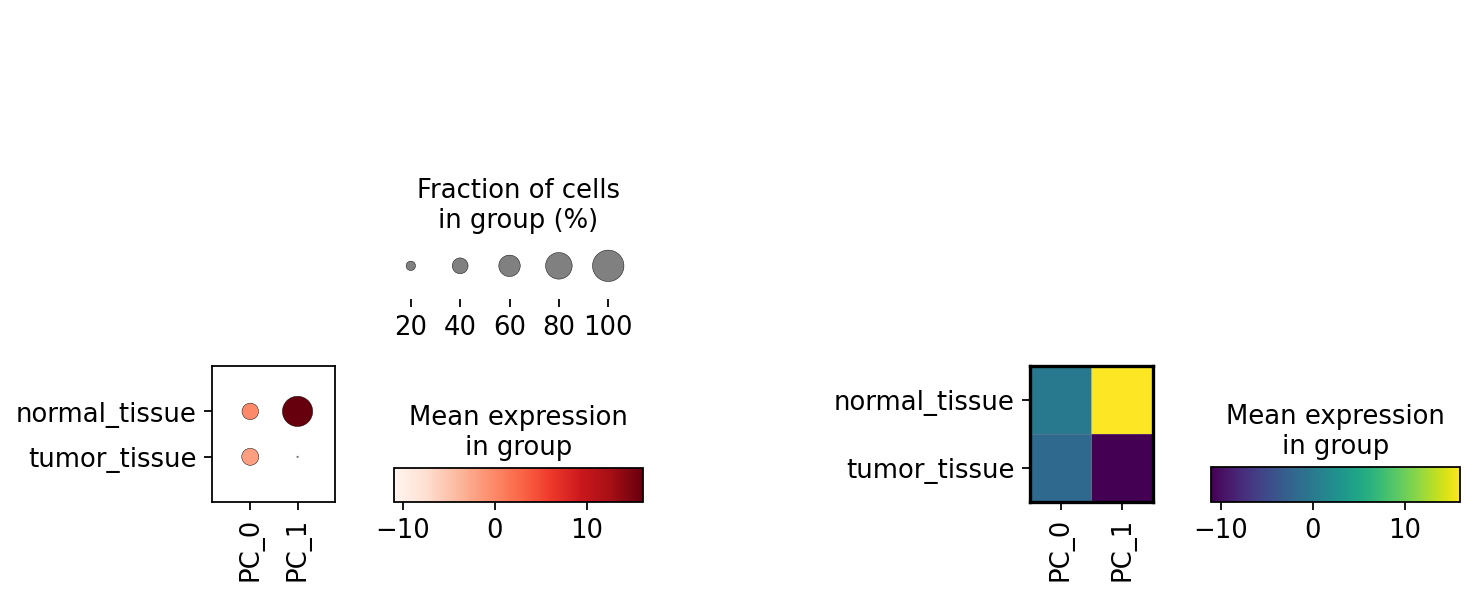

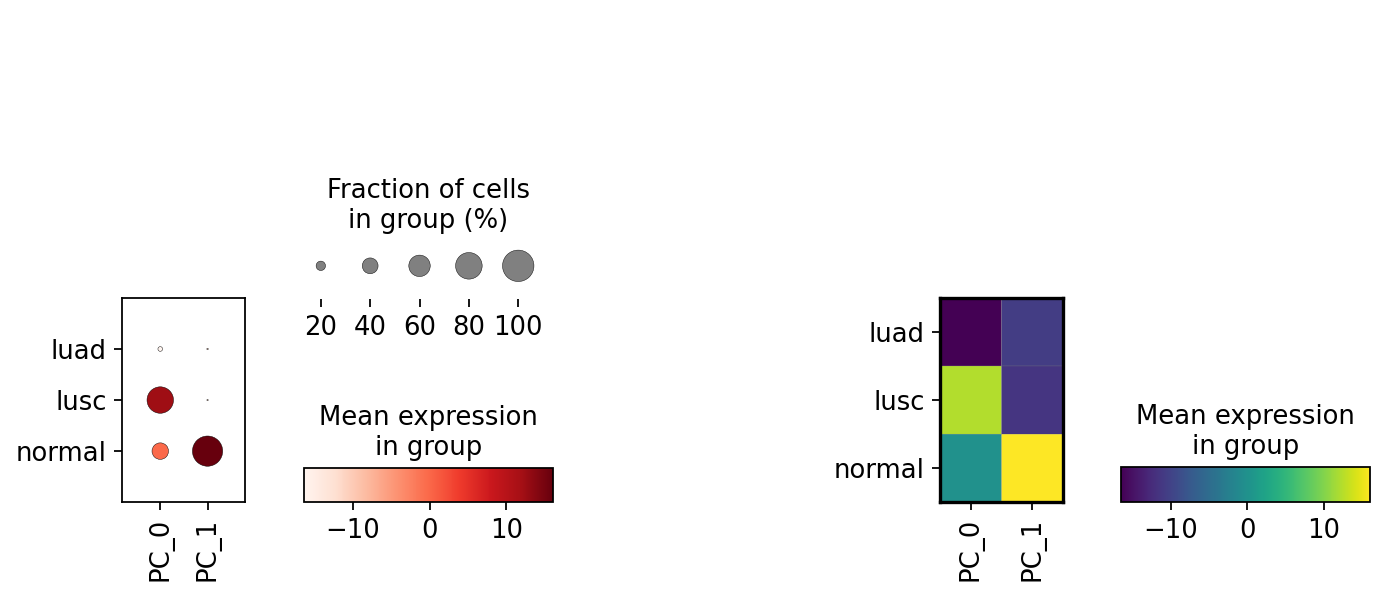

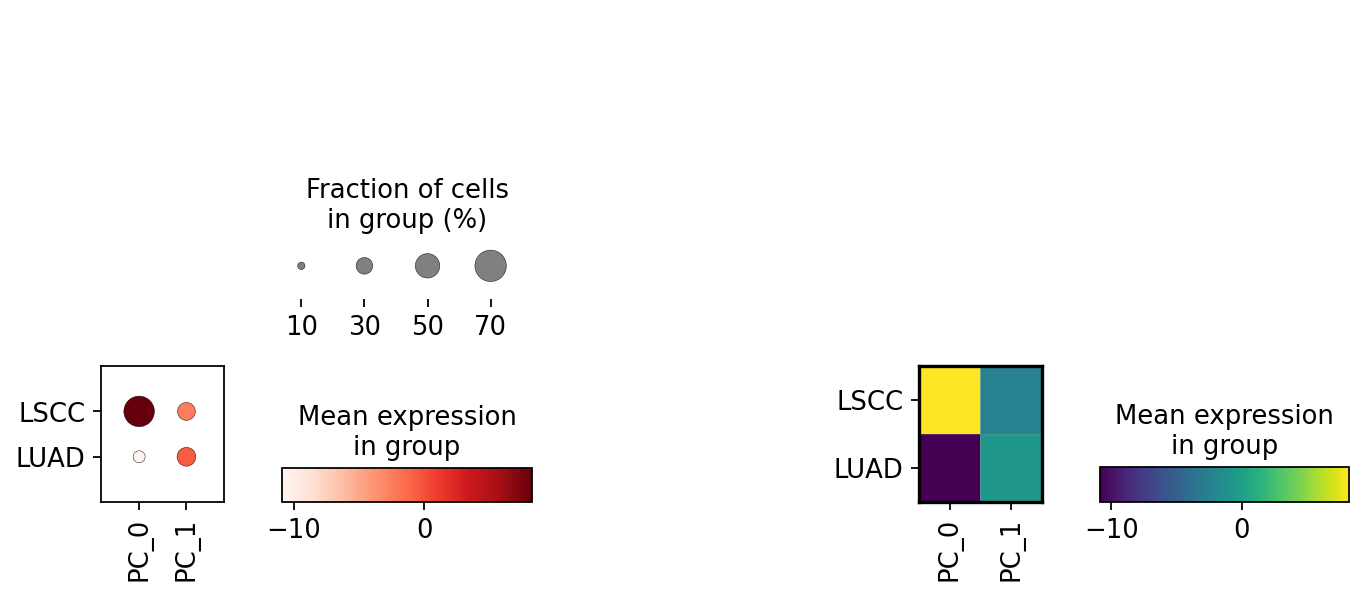

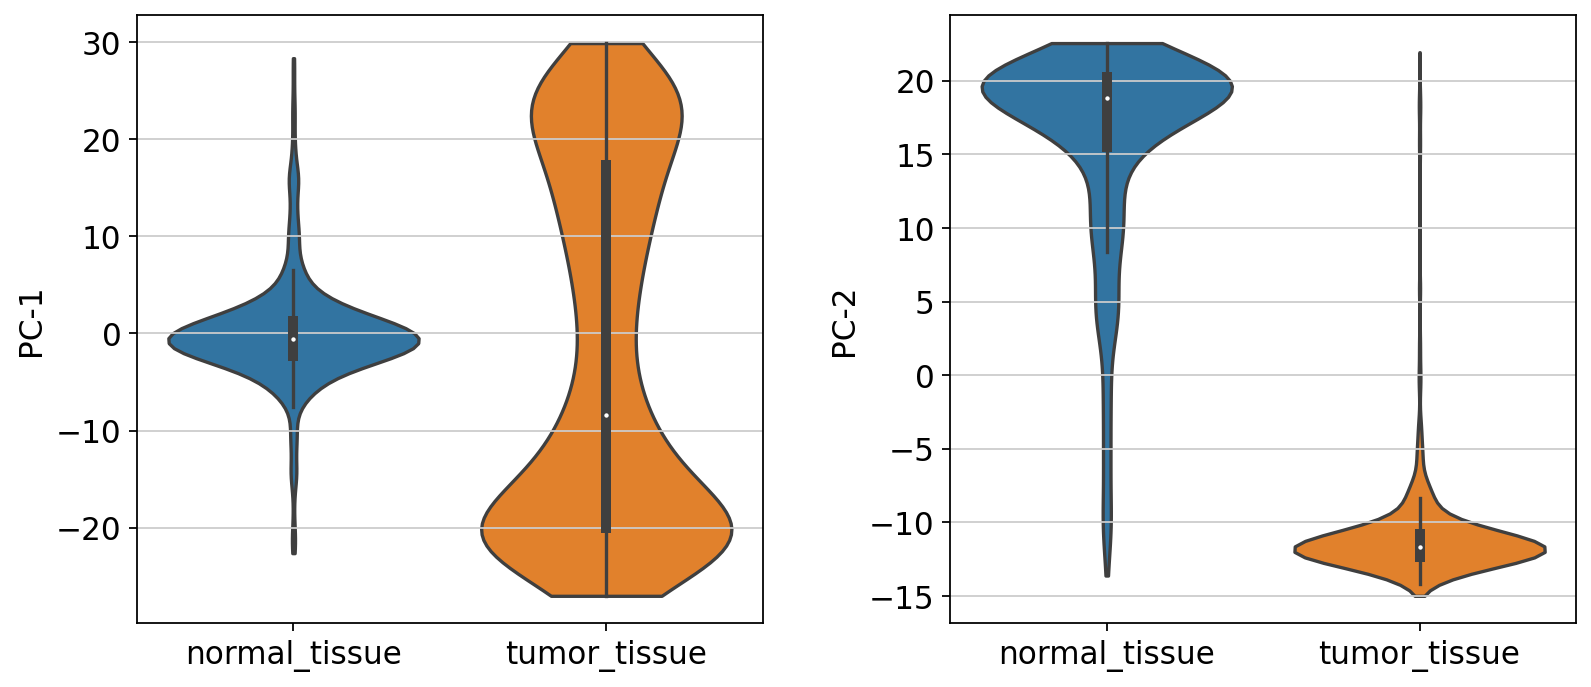

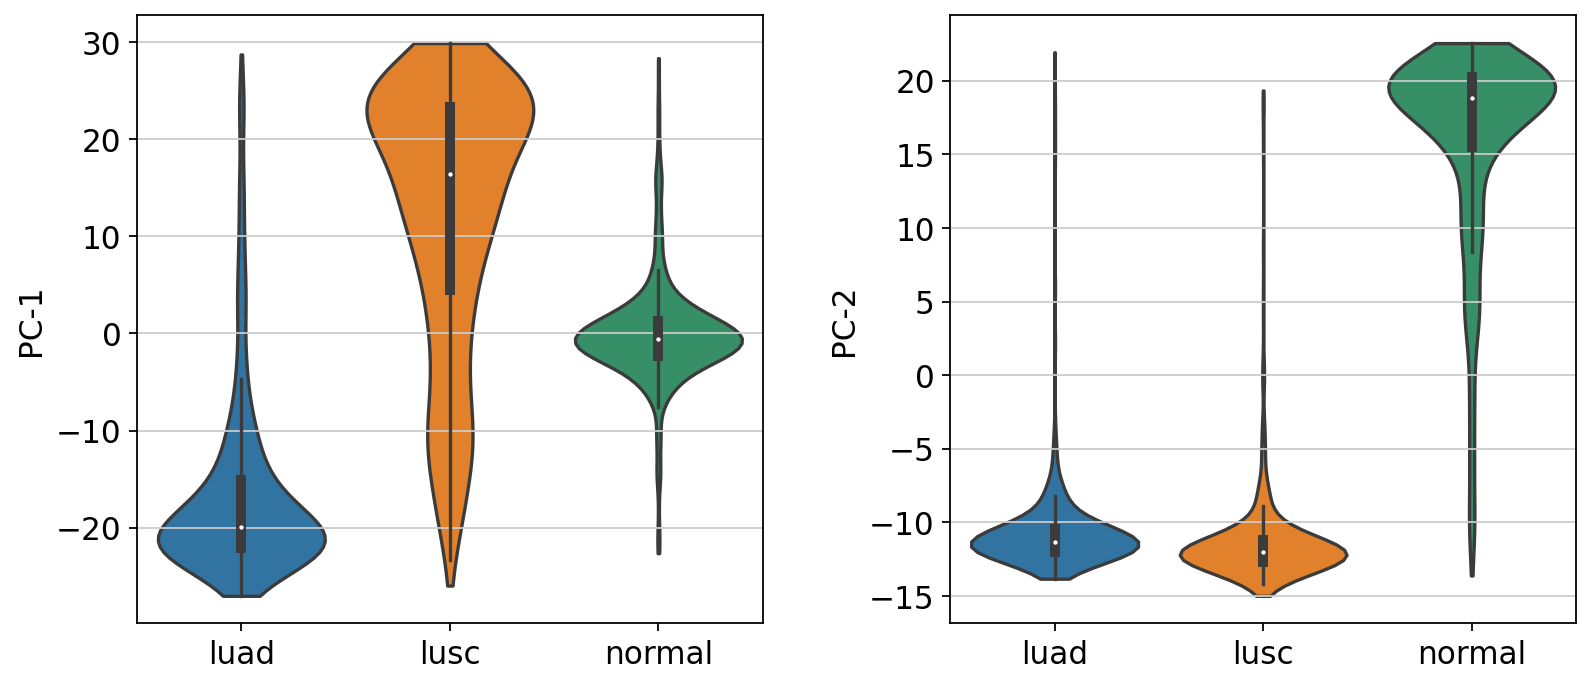

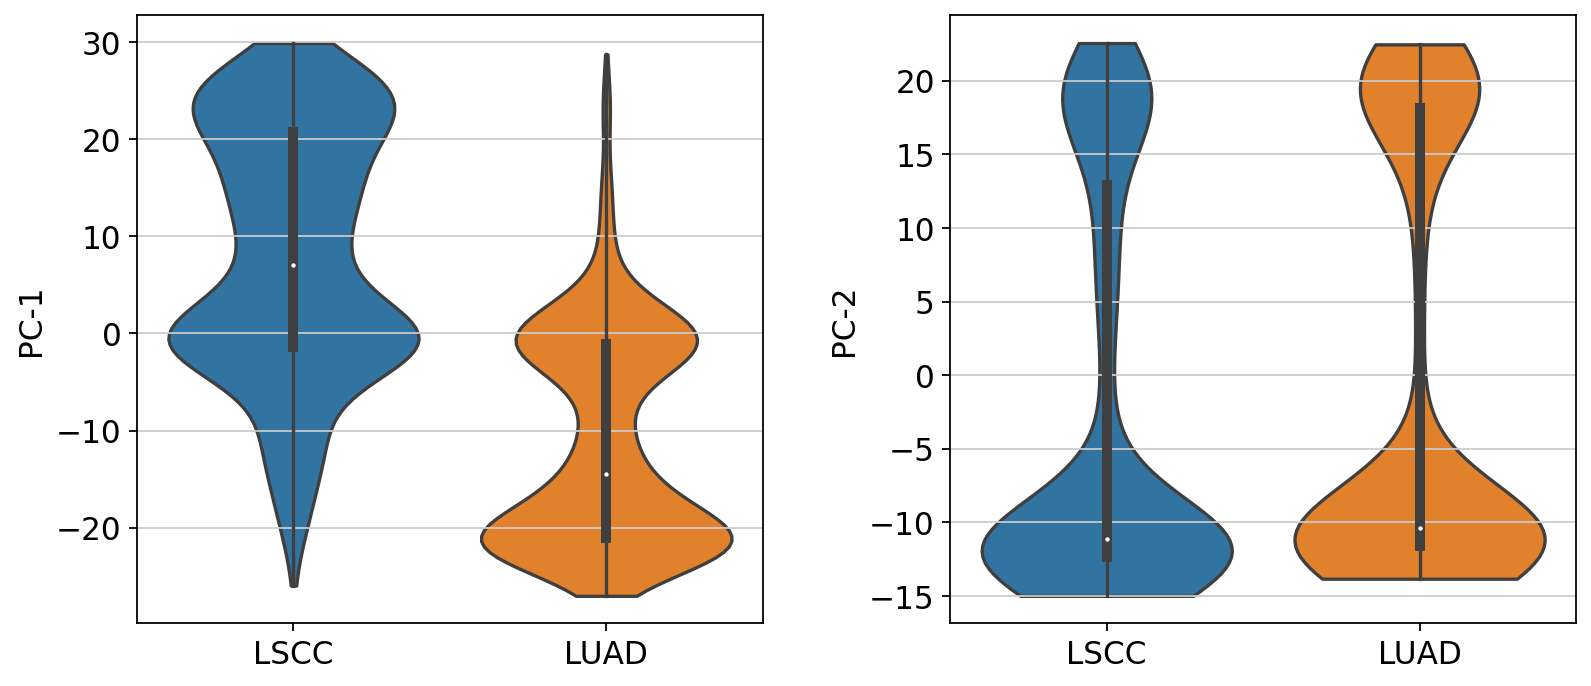

In [11]:
# fig, axs = plt.subplots(1, len(plotting_obs_keys), figsize=(20,4), gridspec_kw={'wspace':0.9})

for key in plotting_obs_keys:
    fig, axs = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'wspace':0.9})
    sc.pl.dotplot(cptac_pca_adata, cptac_pca_adata.var_names[0:2], groupby=key, ax=axs[0], show=False)
    sc.pl.matrixplot(cptac_pca_adata, cptac_pca_adata.var_names[0:2], groupby=key, ax=axs[1], show=False, cmap='viridis')
    
for key in plotting_obs_keys:
    sc.pl.violin(cptac_pca_adata, keys = ['pc1', 'pc2'], groupby=key, stripplot=False, inner='box', ylabel=['PC-1', 'PC-2'], xlabel=None, save='{}.pdf'.format(key))

View of AnnData object with n_obs × n_vars = 321 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'Tumor', 'Specimen_Type', 'Tumor_Histological_Type', 'normal_adjacent_to'
    uns: 'bulk_labels_colors', 'bulk_labels_sizes', 'bulk_merge_labels_colors', 'cohort_names_colors', 'dendrogram_bulk_labels', 'dendrogram_labels', 'dendrogram_leiden', 'labels_colors', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'pca', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'rank_features_wilcoxon_labels', 'tsne', 'umap', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 349 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2', 'Tumor', 'Specimen_Type', 'Tumo

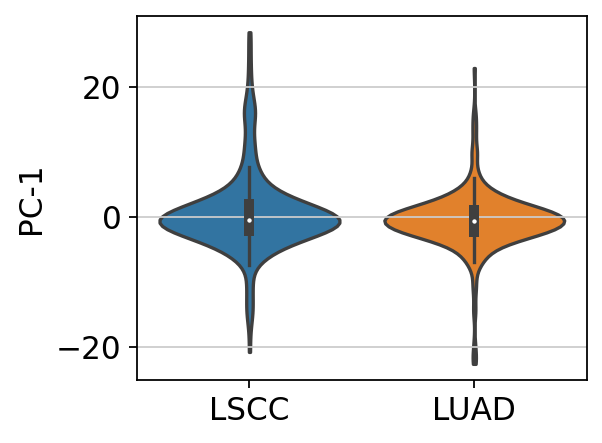

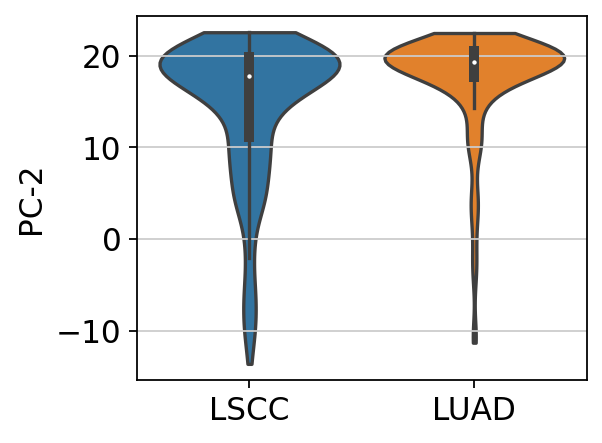

<AxesSubplot: xlabel='PC1', ylabel='PC2'>

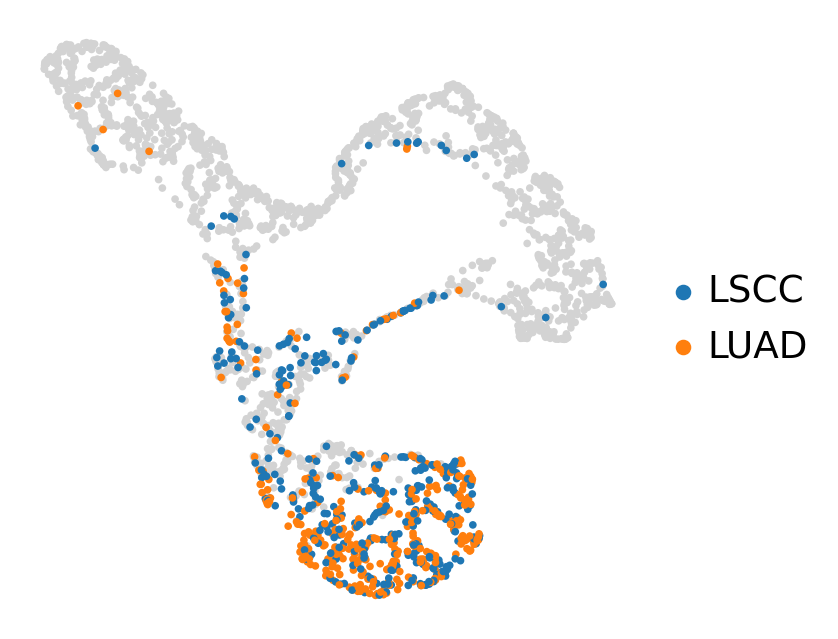

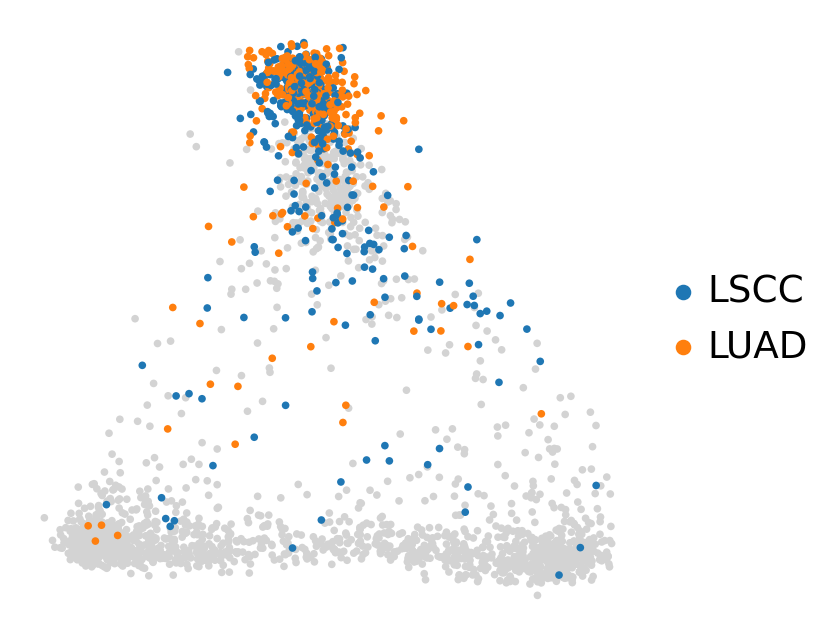

In [12]:
tumor_adjacent = cptac_adata.copy()
# tumor_adjacent.obs['tumor_adjacent'] = tumor_adjacent.obs.loc[tumor_adjacent.obs['Specimen_Type'] == 'normal_tissue', 'Tumor']
normal_adjacent_to = tumor_adjacent.obs.loc[tumor_adjacent.obs['Specimen_Type'] == 'normal_tissue', 'Tumor']
tumor_adjacent.obs['normal_adjacent_to'] = normal_adjacent_to

tumor_adjacent.obs['pc1'] = tumor_adjacent.obsm['X_pca'][:, 0]
tumor_adjacent.obs['pc2'] = tumor_adjacent.obsm['X_pca'][:, 1]

adjacent_to_lusc = tumor_adjacent[tumor_adjacent.obs.normal_adjacent_to == 'LSCC']
adjacent_to_lusc = adjacent_to_lusc[adjacent_to_lusc.obs.model_predictions == 'normal']
print(adjacent_to_lusc)

adjacent_to_luad = tumor_adjacent[tumor_adjacent.obs.normal_adjacent_to == 'LUAD']
adjacent_to_luad = adjacent_to_luad[adjacent_to_luad.obs.model_predictions == 'normal']
print(adjacent_to_luad)


statistic, p_value = tt(adjacent_to_lusc.obs.pc1, adjacent_to_luad.obs.pc1)
print("PC1 T-Test: ", statistic, p_value)

statistic, p_value = tt(adjacent_to_lusc.obs.pc2, adjacent_to_luad.obs.pc2)
print("PC2 T-Test: ", statistic, p_value)

with rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(tumor_adjacent, keys = ['pc1'], groupby='normal_adjacent_to', stripplot=False, inner='box', ylabel=['PC-1'], xlabel=None, save='_cptac_normal_adjacent_pc1.pdf') 

with rc_context({'figure.figsize': (4, 3)}):
    sc.pl.violin(tumor_adjacent, keys = ['pc2'], groupby='normal_adjacent_to', stripplot=False, inner='box', ylabel=['PC-2'], xlabel=None, save='_cptac_normal_adjacent_pc2.pdf')

# with plt.rc_context({'figure.figsize': (4, 4)}):
    # sc.pl.umap(features_adata, color='bulk_labels', groups=[label], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)
sc.pl.umap(tumor_adjacent, color='normal_adjacent_to', show=False, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=False)
sc.pl.pca(tumor_adjacent, color='normal_adjacent_to', show=False, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=False)

PC1 T-Test:  2.501828824274961 0.012868808710141668
PC2 T-Test:  -0.6050563523551167 0.5455827789066119
Silhouette Score for Keratinizing vs Non tissue: 0.04810421


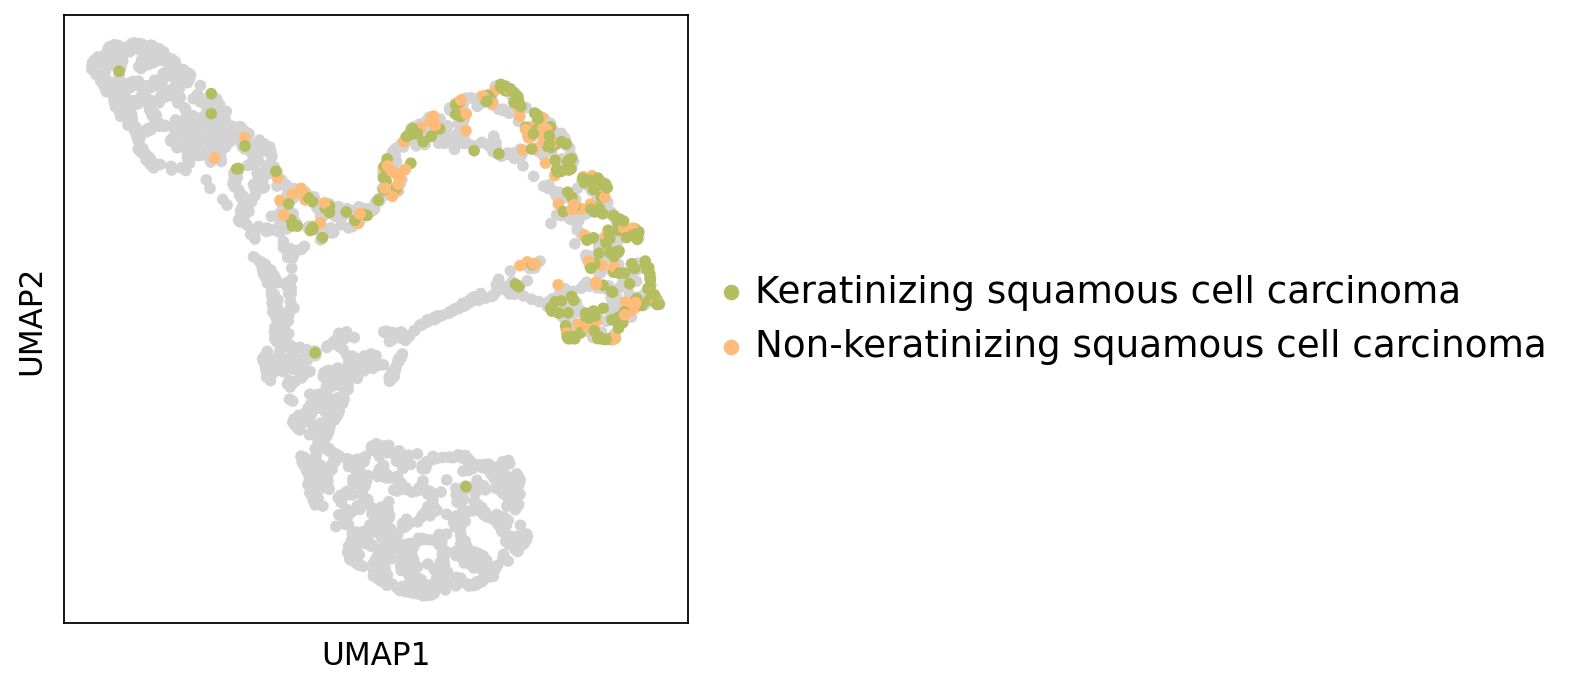

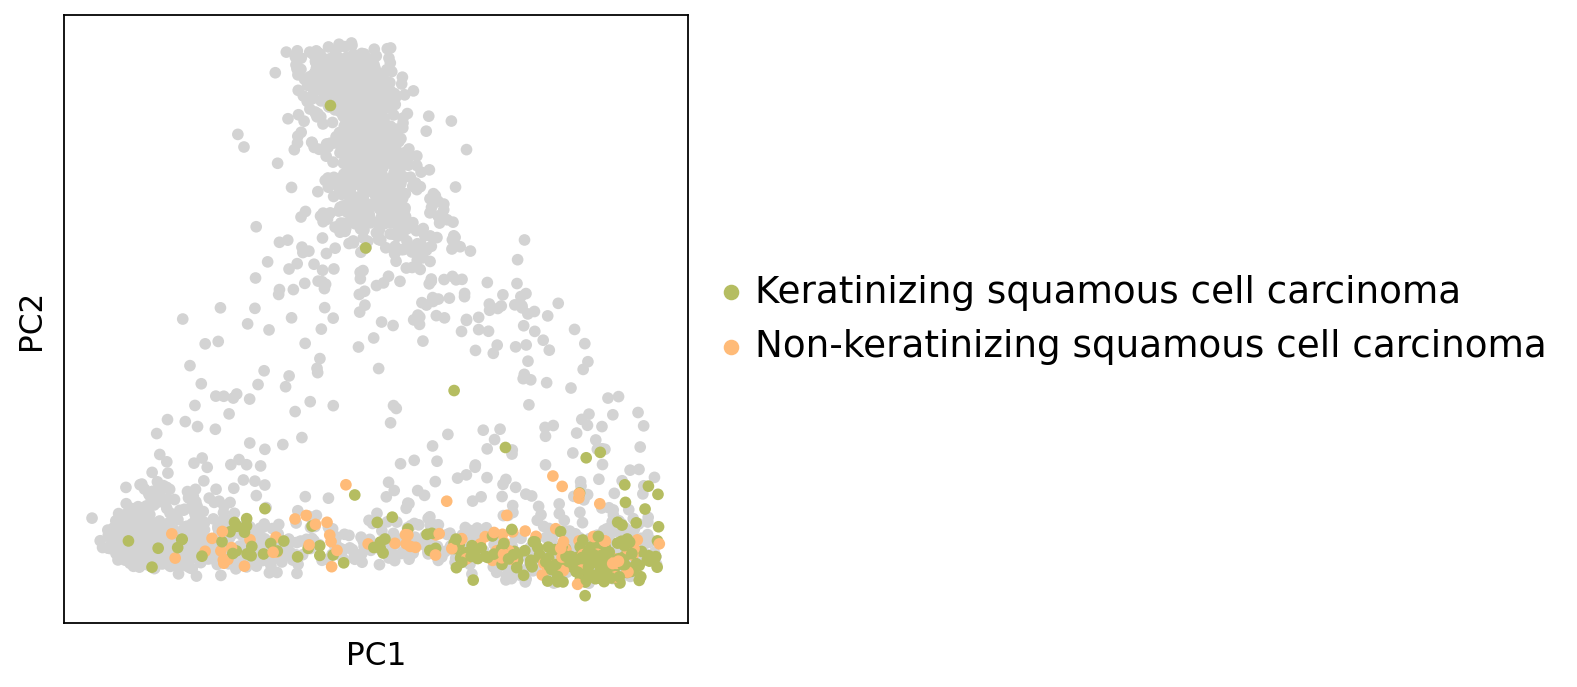

In [13]:
from sklearn.metrics import silhouette_score

keratinizing = cptac_adata[cptac_adata.obs.Tumor_Histological_Type == 'Keratinizing squamous cell carcinoma']
non_keratinizing = cptac_adata[cptac_adata.obs.Tumor_Histological_Type == 'Non-keratinizing squamous cell carcinoma']

statistic, p_value = tt(keratinizing.obs.pc1, non_keratinizing.obs.pc1)
print("PC1 T-Test: ", statistic, p_value)

statistic, p_value = tt(keratinizing.obs.pc2, non_keratinizing.obs.pc2)
print("PC2 T-Test: ", statistic, p_value)

keratinize_or_non = cptac_adata.obs.Tumor_Histological_Type.isin(['Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma'])
sil_score = silhouette_score(cptac_adata.obsm['X_pca'][keratinize_or_non], cptac_adata.obs.Tumor_Histological_Type[keratinize_or_non])
print("Silhouette Score for Keratinizing vs Non tissue:", sil_score)

sc.pl.umap(cptac_adata, color='Tumor_Histological_Type', groups=['Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110 , save='_lusc_subtype.pdf') #
sc.pl.pca(cptac_adata, color='Tumor_Histological_Type', groups=['Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='_lusc_subtype.pdf') # 

PC1 T-Test:  7.90301396432705 5.4084746959967996e-14
PC2 T-Test:  -0.5224040057052207 0.6017798166949738
Silhouette Score for Aggressive vs Indolent: 0.3117958


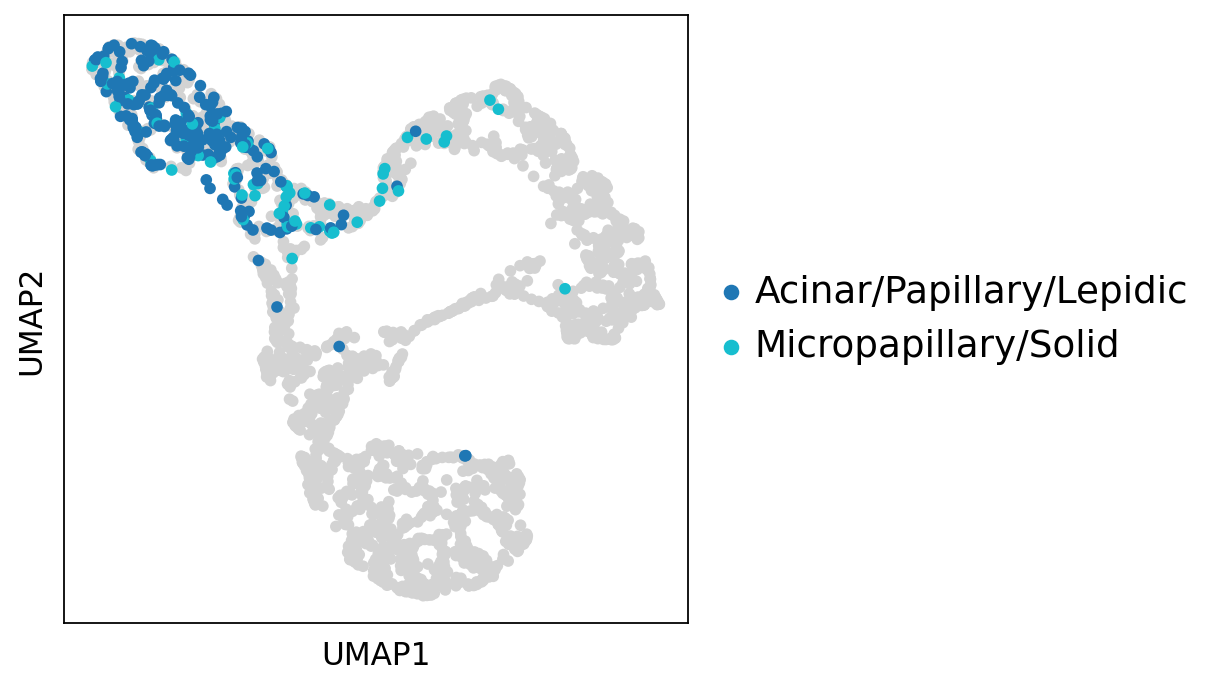

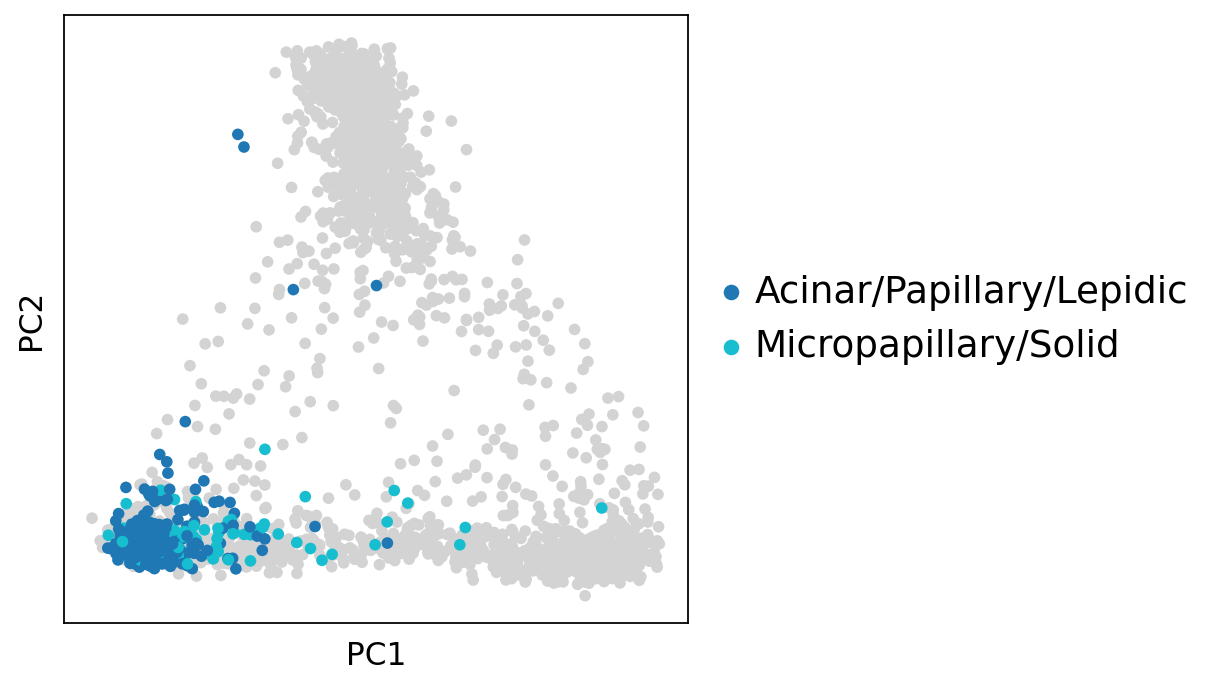

In [14]:
from sklearn.metrics import silhouette_score

aggressive = cptac_adata[cptac_adata.obs.Tumor_Histological_Type == 'Micropapillary/Solid']
indolent = cptac_adata[cptac_adata.obs.Tumor_Histological_Type == 'Acinar/Papillary/Lepidic']

statistic, p_value = tt(aggressive.obs.pc1, indolent.obs.pc1)
print("PC1 T-Test: ", statistic, p_value)

statistic, p_value = tt(aggressive.obs.pc2, indolent.obs.pc2)
print("PC2 T-Test: ", statistic, p_value)

aggressive_or_indolent = cptac_adata.obs.Tumor_Histological_Type.isin(['Micropapillary/Solid', 'Acinar/Papillary/Lepidic'])
sil_score = silhouette_score(cptac_adata.obsm['X_pca'][aggressive_or_indolent], cptac_adata.obs.Tumor_Histological_Type[aggressive_or_indolent])
print("Silhouette Score for Aggressive vs Indolent:", sil_score)

sc.pl.umap(cptac_adata, color='Tumor_Histological_Type', groups=['Micropapillary/Solid', 'Acinar/Papillary/Lepidic'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='_luad-subtype.pdf') # 

# cptac_adata.obs['Tumor_Histological_Type'].replace(['Micropapillary/Solid', 'Acinar/Papillary/Lepidic'], ['Aggressive', 'Indolent'], inplace=True)
sc.pl.pca(cptac_adata, color='Tumor_Histological_Type', groups=['Micropapillary/Solid', 'Acinar/Papillary/Lepidic'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='_luad-subtype.pdf') # 

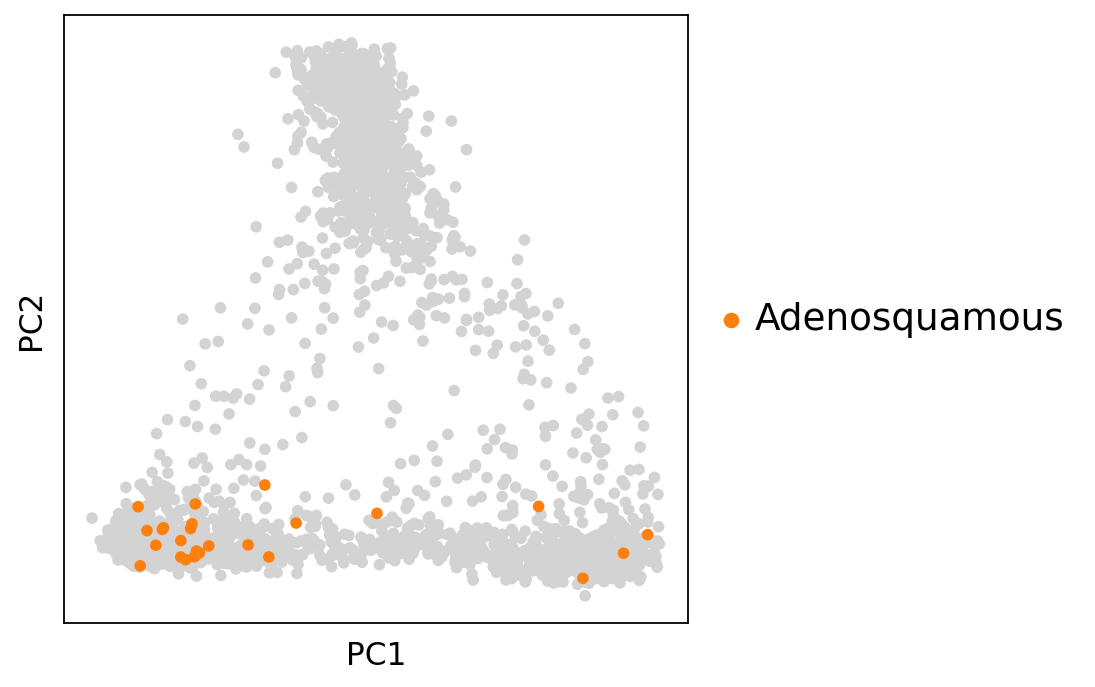

In [15]:
# groups=['Micropapillary/Solid', 'Acinar/Papillary/Lepidic', 'Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma', 'Adenosquamous']
sc.pl.pca(cptac_adata, color='Tumor_Histological_Type', groups=['Adenosquamous'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='adenosquamous_subtype.pdf')

In [16]:
# for type in cptac_adata.obs['Tumor_Histological_Type'].unique():
#     print(type)
# cptac_adata.obs['Tumor_Histological_Type'].replace(['Adenosquamous carcinoma', 'Adenosquamous Carcinoma; at least 66% squamous component', 'adenosquamous carcinoma'], ['Adenosquamous', 'Adenosquamous', 'Adenosquamous'], inplace=True)

# copy column Tumor_Histological_Type to tumor_subtypes in anndata
# cptac_adata.obs['Tumor_Subtypes'] = cptac_adata.obs['Tumor_Histological_Type'].copy()
# cptac_adata.obs['Tumor_Histological_Type'].replace(['Adenosquamous carcinoma', 'Adenosquamous Carcinoma; at least 66% squamous component', 'adenosquamous carcinoma'], ['Adenosquamous', 'Adenosquamous', 'Adenosquamous'], inplace=True)

# sc.pl.pca(cptac_adata, color='Tumor_Histological_Type', groups=['Micropapillary/Solid', 'Acinar/Papillary/Lepidic', 'Keratinizing squamous cell carcinoma', 'Non-keratinizing squamous cell carcinoma', 'Adenosquamous'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110) #, save='lusc_luad_subtype.pdf'

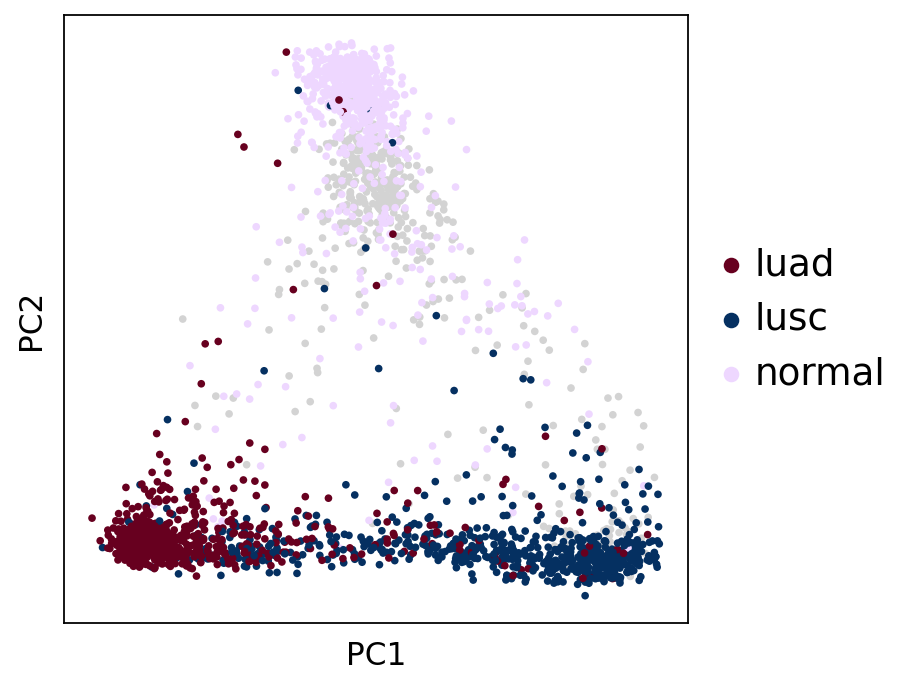

In [17]:
sc.pl.pca(cptac_adata, color='bulk_labels', groups=['normal', 'lusc', 'luad'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True) #, save='lusc_luad_subtype.pdf'